# HW_3

In [1]:
import requests
import re
from pymystem3 import Mystem
import gensim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import urllib.request
from nltk.corpus import stopwords

### 1. Предобработка текста М.Ю. Лермонтова "Герой нашего времени". 

In [2]:
tragedy_text = requests.get('http://lib.ru/INPROZ/DRAJZER/tragedy.txt').text
tragedy_text = re.sub('<.*?>', '', tragedy_text)
tragedy_text = tragedy_text.replace(' -', '')
tragedy_text = tragedy_text.replace(',', '')
tragedy_text = tragedy_text.replace(':', '')
tragedy_text = tragedy_text.replace(';', '')
tragedy_text = tragedy_text.replace('(', '')
tragedy_text = tragedy_text.replace(')', '')
tragedy_text = tragedy_text.replace('[', '')
tragedy_text = tragedy_text.replace(']', '')
tragedy_text = tragedy_text.replace('"', '').split('\n')
tragedy_text = ' '.join(tragedy_text[16:-6]).lower()
tragedy_text = re.split(r'\?|\.|!', tragedy_text)
    
# tragedy_sentences хранит список предложений текста
tragedy_sentences = [elem.strip() for elem in tragedy_text if elem != '']

**Лемматизирую предложения**

In [3]:
tragedy_lemmas = []
m = Mystem()
for sentence in tragedy_sentences:
    tragedy_lemmas.append((''.join(m.lemmatize(sentence))).strip())

In [4]:
with open('American_Tragedy', 'a', encoding='utf-8') as f:
    for elem in tragedy_lemmas:
        f.write(elem+'\n')

### 2. Обучаю модель по параметрам:
* размер вектора 300
* минимальное количество вхождений 5
* окно 5
* количество итераций 50


In [5]:
# data = gensim.models.word2vec.LineSentence('American_tragedy')
# model_tragedy = gensim.models.Word2Vec(data, size=300, window=5, min_count=5, iter=50)

**Вопрос:** сколько получилось слов в этой модели?

**Ответ:**

In [6]:
len(model_tragedy.wv.vocab)

4548

### 3. Использую следующие функции:

**3.1 Модель находит ближайшие 5 слов для:**

* любого частотного слова (союза/местоимения/частицы) 

In [7]:
model_tragedy.wv.most_similar('я', topn=5)

[('вы', 0.6113125085830688),
 ('ты', 0.566344141960144),
 ('мы', 0.5325111746788025),
 ('мама', 0.5287609100341797),
 ('папа', 0.5104323625564575)]

* абстрактного понятия 

In [8]:
model_tragedy.wv.most_similar('любовь', topn=5)

[('страдание', 0.5394915342330933),
 ('страсть', 0.5220407843589783),
 ('красота', 0.5202223062515259),
 ('мечта', 0.5004864931106567),
 ('влечение', 0.4931797385215759)]

* имени главного героя 

In [9]:
model_tragedy.wv.most_similar('клайд', topn=5)

[('он', 0.5719074606895447),
 ('она', 0.38191044330596924),
 ('сэмюэл', 0.30346113443374634),
 ('гортензия', 0.2816394567489624),
 ('смилль', 0.2747874855995178)]

In [10]:
model_tragedy.wv.most_similar('грифитс', topn=5)

[('пейтон', 0.5991516709327698),
 ('говард', 0.5888392925262451),
 ('брейли', 0.5752055048942566),
 ('каппи', 0.5686697959899902),
 ('гилпин', 0.527441143989563)]

* прилагательных "хороший" и "плохой" (или любых других антонимов) 

In [11]:
model_tragedy.wv.most_similar('хороший', topn=5)

[('приятный', 0.40122732520103455),
 ('обыкновенный', 0.3259519338607788),
 ('замечательный', 0.3247135579586029),
 ('дешевый', 0.3204612135887146),
 ('недурной', 0.3175209164619446)]

In [12]:
model_tragedy.wv.most_similar('ужасный', topn=5)

[('пытка', 0.5150730609893799),
 ('страшный', 0.49625349044799805),
 ('внезапный', 0.44788092374801636),
 ('безнадежный', 0.43461987376213074),
 ('приключение', 0.43278467655181885)]

_Комментарий_
- Модель хорошо сработала для местоимения _я_, показав возможные синонимы.  
- Модель для абстрактного понятия нашла (вполне себе) синонимы: _страсть, влечение, романтика_. 
- К фамилии главного героя модель подобрала в качестве синонимов другие встречабщиеся в тексте фамилии. 
- Для _хороший_ модель подобрала синонимы _приятный, приличный, солидный, недурной_ , а для _плохой_ : _страшный_.

**3.2 Модель находит семантическую пропорцию**

**Выберу следующую пропорцию:** _богатый - сэмюэл : бедный - клайд._ Выбираю эту пару, так как ее элементы наиболее противоположны друг другу, модель должна это заметить и выдать правильный результат. 

*Сэмюэл - богатый дядя главного героя, Клайда. А Клайд крайне беден. 

*Я обучала модель несколько раз, примечательно, что в первый раз модель сработала верно.

In [13]:
model_tragedy.wv.most_similar(positive=['богатый', 'клайд'], negative=['бедный'])[0:2]

[('он', 0.41551071405410767), ('сэмюэл', 0.2905289828777313)]

**Выберу следующую пропорцию:** _богатый - сэмюэл : бедный - эйса (лемматизирован как эйс)._ Выбираю эту пару, так как ее элементы наиболее противоположны друг другу, модель должна это заметить и выдать правильный результат. 

*Сэмюэл - богатый фабрикант. Эйс(а) - бедный.

In [14]:
model_tragedy.wv.most_similar(positive=['бедный', 'сэмюэл'], negative=['эйс'])[0:2]

[('фабрикант', 0.4547841548919678), ('ликургский', 0.4446631073951721)]

**3.3 Модель находит лишнее в списке слов**

Роберта, Сондра, Гортензия - девушки, с которыми у главного героя Клайда были отношения. Сэмюэл - дядя Клайда. Лишний Сэмюэл. 

In [15]:
model_tragedy.wv.doesnt_match('роберта сондра гортензия сэмюэл'.split())

/Users/mariabocharova/opt/anaconda3/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'сэмюэл'

Лишняя - Сондра, так как Клайд не убивал ее. 

In [16]:
model_tragedy.wv.doesnt_match('тело река убийство сондра'.split())

'сондра'

_Комментарий_

Хороший результат, модель!

### 4. Делаю визуализацию с помощью PCA
попробуйте на именах героев (4+ имен, можно брать имя и фамилию героя отдельно, это даже интересно): это отражает их отношения / их характеры?

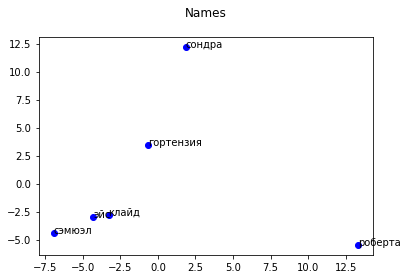

In [39]:
names = ['клайд', 'роберта', 'сондра', 'сэмюэл', 'эйс', 'гортензия']

words = [name.lower().strip() for name in names if name in model_tragedy.wv.vocab]
not_in_vocab = [name for name in names if name not in model_tragedy.wv.vocab]
not_in_vocab = ', '.join(["'"+elem+"'" for elem in not_in_vocab])
if len(not_in_vocab) > 0:
    print(f'К сожалению, {not_in_vocab} нет в словаре.')

X = model_tragedy.wv.__getitem__(words)

pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.scatter(coords[:, 0], coords[:, 1], color='blue')
plt.title('Names\n')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

_Комментарии_

Модель отражает отношения героев: Сэмюэл, Эйс(а) и Клайд - родственники. 

### 5. Заменяю все слова (кроме служебных) из предложения на ближайшие по векторам

In [40]:
stops = set(stopwords.words('russian') + [
    'это', 'весь', 'который', 'мочь', 
    'свой', 'ещё', 'всё', 'оно', 'то', 
    'кто', 'что'
])

# Стоп-слова оставляю на месте, а если слово не входит в model_tragedy.wv.vocab, то ставлю '_'.
sentence1 = 'ведь вы же позволять многий парень за вы ухаживать'
sentence1_new = []
for word in sentence1.split():
    if word not in stops and word in model_tragedy.wv.vocab:
        sentence1_new.append(str(model_tragedy.wv.most_similar(word, topn=1)[0][0]))
    elif word in stops:
        sentence1_new.append(word)
    elif word not in stops and word not in model_tragedy.wv.vocab:
        sentence1_new.append('_')
sentence1_new = ' '.join(sentence1_new)
print(sentence1_new)

ведь вы же представлять многие еврей за вы наблюдать
